# Getting parameters from runs with py3DCORE_h4c

In [25]:
%load_ext autoreload

%autoreload 2

import heliosat as heliosat
import logging as logging
import datetime as datetime
import numpy as np
import os as os
import pickle as pickle
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns

from py3dcore_h4c.fitter.base import custom_observer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from heliosat.util import sanitize_dt

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

For plotting, we need the following information about the times.

In [27]:
t_launch = datetime.datetime(2022, 9, 5, 18, 45, tzinfo=datetime.timezone.utc) # launch time assumed at CME impact at PSP at 14.72 Rs

t_s_solo = datetime.datetime(2022, 9, 7, 0, 30, tzinfo=datetime.timezone.utc) 
t_e_solo = datetime.datetime(2022, 9, 8, 5, tzinfo=datetime.timezone.utc)

t_solo = [
        datetime.datetime(2022, 9, 7, 2, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 4, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 6, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 8, tzinfo=datetime.timezone.utc)
    ]

In [28]:
# specify directory from which to read pickle file (= results of runs)
path = 'solo06092022_heeq_512_4FP/'

# Get the list of all files in path
dir_list = sorted(os.listdir(path))

resfile = []
respath = []
# we only want the pickle-files
for file in dir_list:
    if file.endswith(".pickle"):
        resfile.append(file) 
        respath.append(os.path.join(path,file))
        print(os.path.join(path, file))       

solo06092022_heeq_512_4FP/00.pickle
solo06092022_heeq_512_4FP/01.pickle
solo06092022_heeq_512_4FP/02.pickle
solo06092022_heeq_512_4FP/03.pickle
solo06092022_heeq_512_4FP/04.pickle
solo06092022_heeq_512_4FP/05.pickle
solo06092022_heeq_512_4FP/06.pickle
solo06092022_heeq_512_4FP/07.pickle
solo06092022_heeq_512_4FP/08.pickle
solo06092022_heeq_512_4FP/09.pickle
solo06092022_heeq_512_4FP/10.pickle
solo06092022_heeq_512_4FP/11.pickle
solo06092022_heeq_512_4FP/12.pickle
solo06092022_heeq_512_4FP/13.pickle


INFO:py3dcore_h4c.fitter.base:Using HelioSat to retrieve observer data


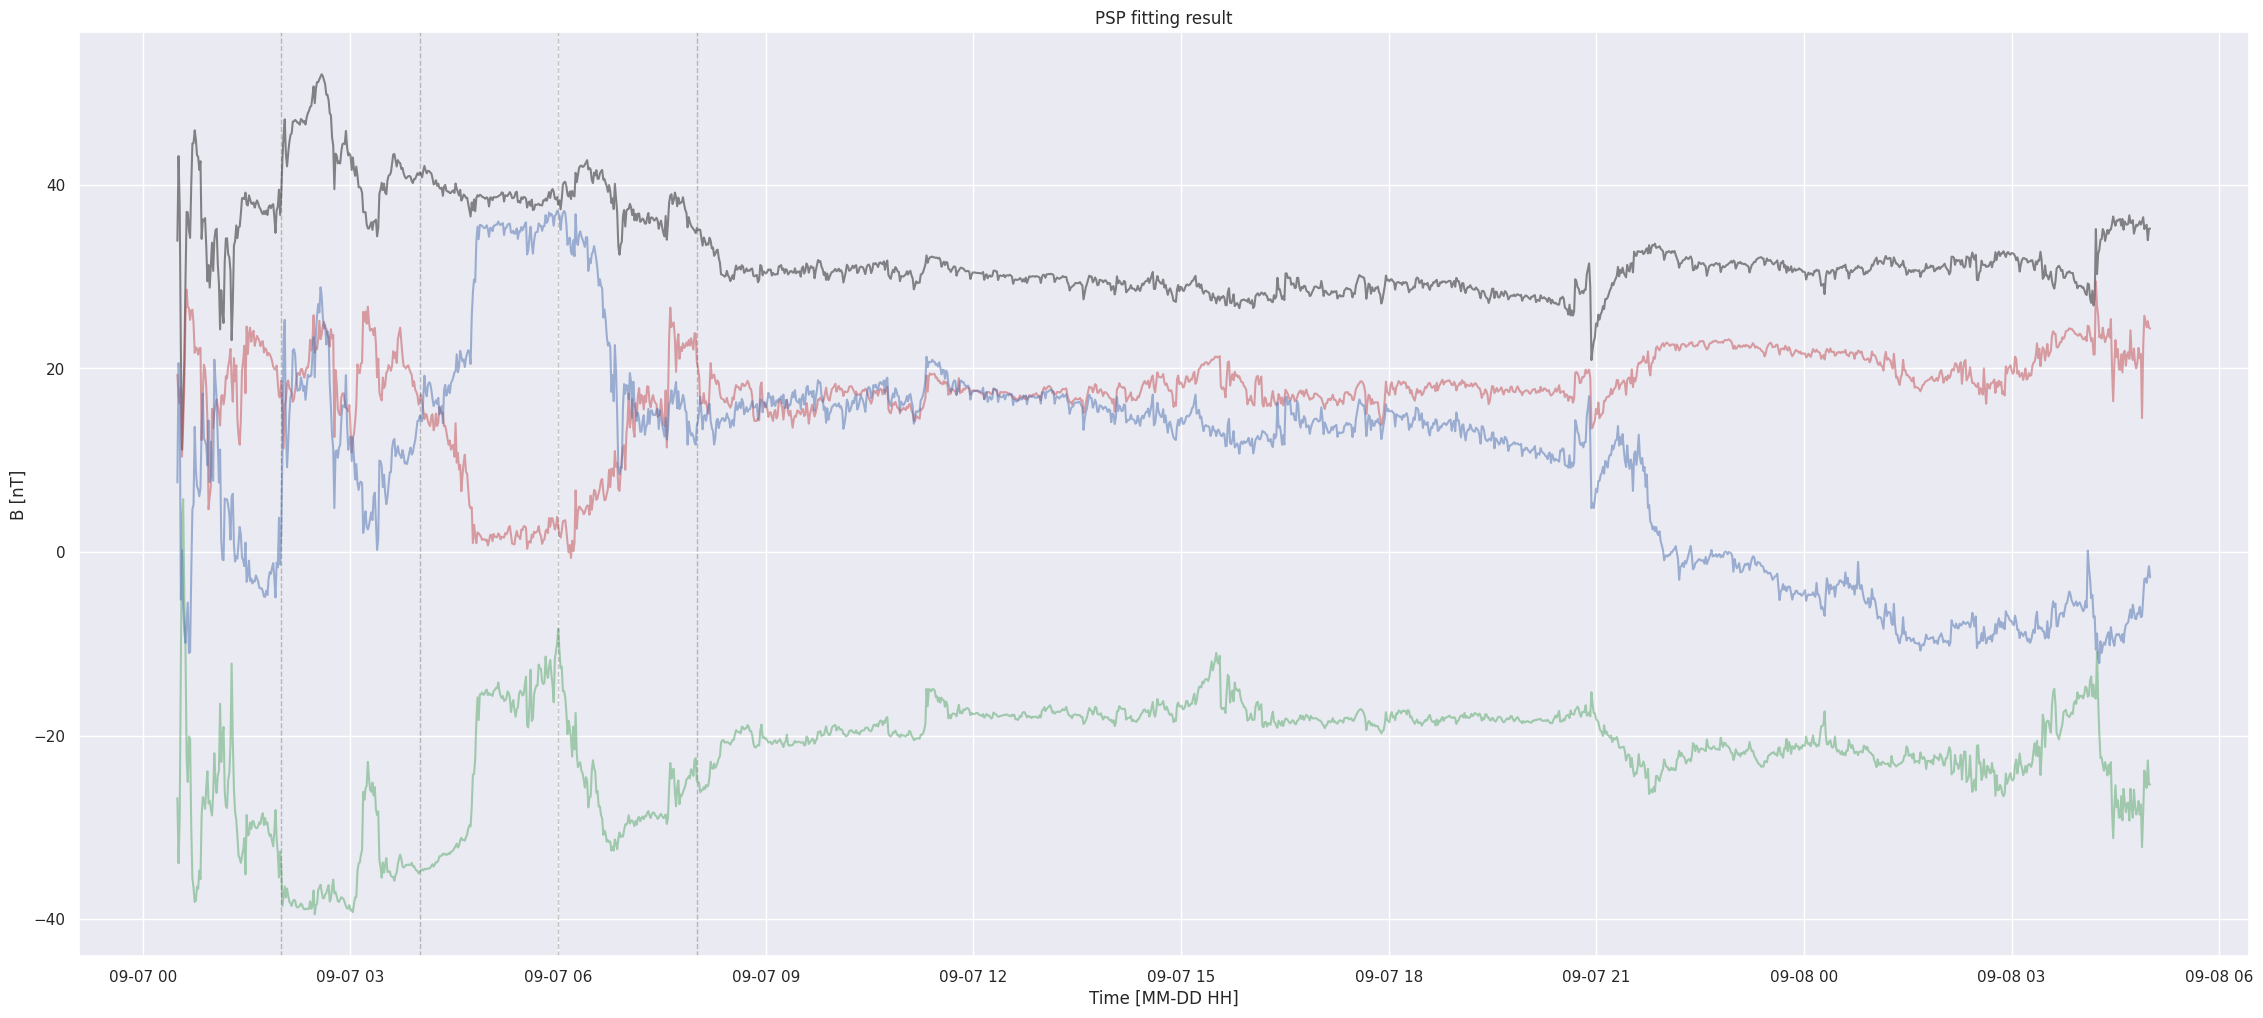

In [30]:
# plot the results 

#t_s_psp = datetime.datetime(2022, 6, 2, 10, tzinfo=datetime.timezone.utc)
#t_e_psp = datetime.datetime(2022, 6, 3, 2, tzinfo=datetime.timezone.utc)

obs_obj = custom_observer('solo_2022sep.p')

# get measurements from PSP via heliosat
psp_t, psp_b = obs_obj.get([t_s_solo, t_e_solo], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

# get ensemble_data
ed = py3dcore_h4c.generate_ensemble(respath[-1], psp_t, reference_frame="HEEQ", reference_frame_to="HEEQ", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("PSP fitting result")
plt.plot(psp_t, np.sqrt(np.sum(psp_b**2, axis=1)), "k", alpha=0.5)
plt.plot(psp_t, psp_b[:, 0], "r", alpha=0.5)
plt.plot(psp_t, psp_b[:, 1], "g", alpha=0.5)
plt.plot(psp_t, psp_b[:, 2], "b", alpha=0.5)
plt.fill_between(psp_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(psp_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(psp_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(psp_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_solo:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.savefig(path+'%s.png' %resfile[-1])    
plt.show()

In [31]:
# read from pickle file
file = open(respath[-1], "rb")
data = pickle.load(file)
file.close()

# get overview of whats in pickle file
cnt = 0
for item in data:
    print(item)
    cnt += 1
    
# get index ip for run with minimum eps    
epses_t = data["epses"]
ip = np.argmin(epses_t)    

# get parameters (stored in iparams_arr) for the run with minimum eps
model_objt = data["model_obj"]
iparams_arrt = model_objt.iparams_arr
iparams_arrt[ip]

locked
dt_0
model_kwargs
observers
model
iter_i
hist_eps
hist_time
hist_eps_dim
model_obj
data_obj
epses


array([ 0.0000000e+00, -6.2876453e+01,  5.7403049e+01,  6.5963242e+01,
        2.9741254e-01,  2.7379618e+00,  1.2472202e+01,  1.5283033e+03,
       -1.4494401e+01,  1.1400000e+00,  1.6400000e+00,  1.7960369e+01,
        2.1013734e-01,  4.1461264e+02], dtype=float32)

## Use scatter plot to plot range of all runs

In [32]:
df = pds.DataFrame(iparams_arrt)
cols = df.columns.values.tolist()

# drop first column, and others in which you are not interested
df.drop(df.columns[[0, 9, 10]], axis=1, inplace=True)

# rename columns
df.columns = ['lon', 'lat', 'inc', 'D1AU', 'delta', 'launch radius', 'init speed', 't factor', 'B1AU', 'gamma', 'vsw']
print(df.head())

         lon        lat        inc      D1AU     delta  launch radius  \
0 -63.672756  55.459656  88.730743  0.308814  3.597897      19.940569   
1 -31.175518  51.522446  65.715630  0.337230  2.759096      18.704647   
2 -48.435818  57.769581  75.270470  0.340579  1.670598      17.080763   
3 -61.331505  57.668423  77.707939  0.347326  2.888337      14.610422   
4 -25.616104  55.352039  71.318634  0.320065  3.230166      11.643437   

    init speed  t factor       B1AU     gamma         vsw  
0  1686.607910  4.065476  16.804501  0.212118  382.101349  
1  1532.233398  2.511690  14.597653  0.208224  422.751740  
2  1520.179077 -6.761118  15.631385  0.229873  422.247955  
3  1631.759033 -4.756777  15.386237  0.244315  422.000793  
4  1506.265625  9.262519  16.014717  0.207511  447.481445  


In [ ]:
sns.set_style('white')
sns.set()

g = sns.pairplot(df, 
                 corner=True,
                 plot_kws=dict(marker="+", linewidth=1)
                )
g.map_lower(sns.kdeplot, levels=[0.05, 0.32], color=".2") #  levels are 2-sigma and 1-sigma contours
g.savefig(path+'scatter_plot_matrix.png')
plt.show()